# Model Training
After data preparation and the model evaluation I want know to train the model with the whole data and check it with a real and fake news article to check the trained model.

## Import of required libraries
Those libraries are used in the notebook to perform the data preparation. Maybee you need to install them first with `pip install <library>`.  

In [14]:
#Data Pre-processing
import numpy as np
import pandas as pd
import os

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline

#Handling Warnings
import warnings
warnings.filterwarnings('ignore')

#Text pre-processing
from nltk.corpus import stopwords
import string, re
from bs4 import BeautifulSoup
from wordcloud import WordCloud

#Modeling
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import text, sequence
from keras_preprocessing.sequence import pad_sequences
from nltk.tokenize.toktok import ToktokTokenizer
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

#Deep Learning
import tensorflow as tf

## Import Dataset
As first step I will import the cleaned dataset from the previous notebook "01_data_prep".

In [15]:
new_data = pd.read_csv('../Machine_Learning2_Project/20_model_evaluation/20_cleaned_data.csv')
new_data.head()

,Unnamed: 0,news,real/fake
0,0,us budget fight loom republican flip fiscal sc...,Real
1,1,us militari accept transgend recruit monday pe...,Real
2,2,senior us republican senat let mr mueller job ...,Real
3,3,fbi russia probe help australian diplomat tipo...,Real
4,4,trump want postal servic charg much amazon shi...,Real


The column "Unnamed: 0" is the index column but it is not needed anymore. So I will drop it.

In [16]:
del new_data['Unnamed: 0']
new_data.head()

,news,real/fake
0,us budget fight loom republican flip fiscal sc...,Real
1,us militari accept transgend recruit monday pe...,Real
2,senior us republican senat let mr mueller job ...,Real
3,fbi russia probe help australian diplomat tipo...,Real
4,trump want postal servic charg much amazon shi...,Real


I think there could be some issues with the values "Real" and "Fake" in the model training, so I decided to change the Values into "1" for "Real" and "0" for "Fake". With the numbers I can easier work with the values in the model training.

In [17]:
mapping = {'Real': 1, 'Fake': 0}
new_data['real/fake'] = new_data['real/fake'].map(mapping)
new_data.head()


,news,real/fake
0,us budget fight loom republican flip fiscal sc...,1
1,us militari accept transgend recruit monday pe...,1
2,senior us republican senat let mr mueller job ...,1
3,fbi russia probe help australian diplomat tipo...,1
4,trump want postal servic charg much amazon shi...,1


I also noticed that the slash in the name of the column "real/fake" becomes a problem later on in the notebook, so I change the name of the column to "classification" here as well.

In [24]:
new_data.rename(columns={'real/fake': 'classification'}, inplace=True)
new_data.head()

,news,classification
0,us budget fight loom republican flip fiscal sc...,1
1,us militari accept transgend recruit monday pe...,1
2,senior us republican senat let mr mueller job ...,1
3,fbi russia probe help australian diplomat tipo...,1
4,trump want postal servic charg much amazon shi...,1


As preparation for the training I will create a new dataframe. In this dataframe is split into train, dev and test data with the ratio 60%, 20% and 20%. The reproduce the testing results I will set the random state to 1.

In [26]:
np.random.seed(1)

def train_dev_test_split(df, target_col, proportions):

    assert(sum(proportions) == 1.0)
    train_size, dev_size, test_size = proportions
    
    false_index = df[df[target_col] == 1].index
    true_index = df[df[target_col] == 0].index
    
    false_train_indices = np.random.choice(false_index, int(train_size * len(false_index)), replace=False)
    true_train_indices = np.random.choice(true_index, int(train_size * len(true_index)), replace=False)
    train_indices = list(false_train_indices) + list(true_train_indices)
    train = df.iloc[train_indices]

    rem_df = df.iloc[list(set(df.index)-set(train_indices))]
    rem_false_index = rem_df[rem_df[target_col] == 1].index
    rem_true_index = rem_df[rem_df[target_col] == 0].index
    false_dev_indices = np.random.choice(rem_false_index, int((dev_size / (dev_size + test_size)) * len(rem_false_index)), replace=False)
    true_dev_indices = np.random.choice(rem_true_index, int((dev_size / (dev_size + test_size)) * len(rem_true_index)), replace=False)
    dev_indices = list(false_dev_indices) + list(true_dev_indices)
    dev = df.iloc[dev_indices]

    test_indices = list(set(df.index) - set(train_indices + dev_indices))
    test = df.iloc[test_indices]
    return train, dev, test

train, dev, test = train_dev_test_split(new_data, 'classification', (0.6, 0.2, 0.2))
X_train, X_dev, X_test = train.news, dev.news, test.news
y_train, y_dev, y_test = train.classification, dev.classification, test.classification


Let's now check the datasplit in the train, dev and test data. They should have similar ratios of real and fake news.

<Axes: xlabel='classification', ylabel='count'>

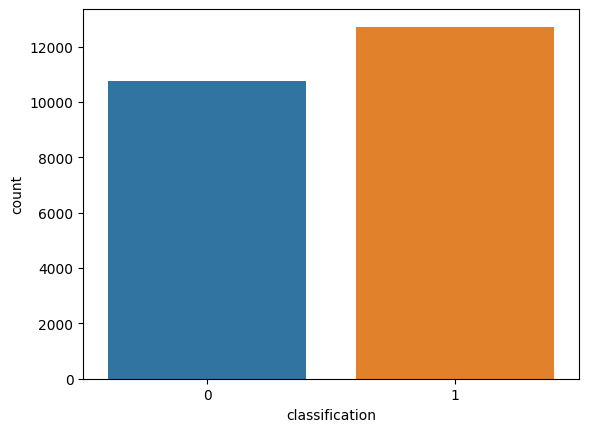

In [27]:
sns.countplot(x='classification', data=train)

<Axes: xlabel='classification', ylabel='count'>

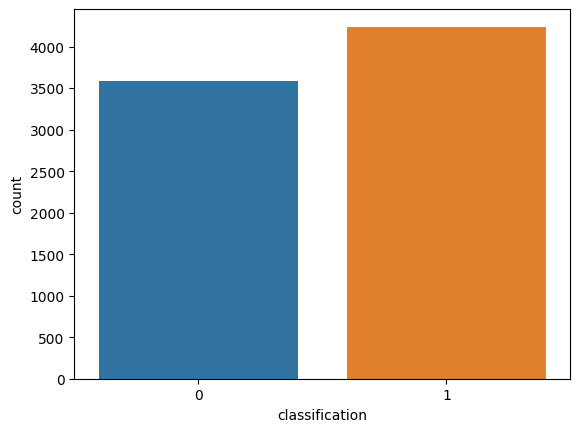

In [28]:
sns.countplot(x='classification', data=dev)

<Axes: xlabel='classification', ylabel='count'>

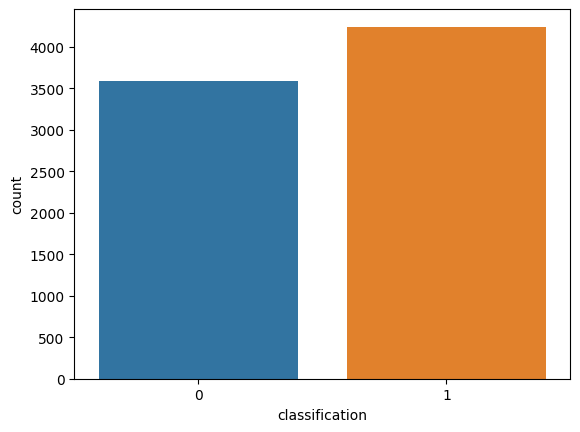

In [29]:
sns.countplot(x='classification', data=test)

The data are good, so let's use it for the next steps.

In the next step, I limit the number of words (features) to 10,000 in the vocabulary and the number of words within a news story to 300 words. I do this to reduce the "size" of the model a bit and also because this is a classification and not a large language model.

In [30]:
max_features = 10000
max_len = 300

In [31]:
# Fit the tokenizer on the training data
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

In [32]:
# Tokenize and pad each set of texts
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=max_len)

tokenized_dev = tokenizer.texts_to_sequences(X_dev)
X_dev = pad_sequences(tokenized_dev, maxlen=max_len)

tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=max_len)

## Model Training
The first step in the model is to use the GloVe embedding to assign each word to a feature vector which has some meaning in the context of the model, instead of an arbitrary token. For this I will use the GloVe embeddings from an external source.

The embedding file is quite large and will not fitt into the github repository. So please download the file from this source: https://www.kaggle.com/datasets/bertcarremans/glovetwitter27b100dtxt and save it in the folder "Machine_Learning2_Project/30_train_model/30_inputs" or change the source path in the next cell.

In [33]:
EMBEDDING_FILE = '../Machine_Learning2_Project/30_train_model/30_inputs/30_glove.twitter.27B.100d.txt'

Now I will create a dictionary with the GloVe embeddings. The dictionary will contain the word as key and the embedding as value.

In [34]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict((get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf-8')))


Now, based on the dictionary, I create an embedding matrix that contains the embedded representations for the words that occur in the pre-processed text. This matrix can then be used in an NLP model as part of the embedding layer to learn the word representations during training and achieve better performance.

In [35]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()

embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Now the embedding matrix is created and I need to set some other hyperparameters, before finally creating the network architecture. I want to use a batch gradient descent, so I need to set a batch size and a number of epochs. 

In [36]:
batch_size = 256
epochs = 3
embed_size = 100

As a further regularisation technique, I add a reduction in the learning rate.

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In several examples on the internet I have seen that for similar tasks and models they have used LTSM. This led me to disregard my model evaluation from the notebook "02_model_eval" and to use too the LTSM instead. 
The Long Short-Term Memory (LSTM) model is a subtype of Recurrent Neural Networks (RNN). It is used to recognise patterns in data sequences, such as those that appear in sensor data, stock prices or natural language. RNNs are able to do this because, in addition to the actual value, they also include its position in the sequence in the prediction.

In [38]:
model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

Now I check the model and get an overview of the structure of the model and the number of parameters.

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


Now the training of the model can be carried out.
As preparation, I have already trained the model once with 10 Epochs. This took about 24 hours and resulted in an accuracy of 0.9966 and a loss of 0.0093 after the 10 epochs.

For the further training of the model, I reduced the number of epochs to 3 so that less time and fewer resources are needed. After the 3 epochs, the accuracy is 0.9904 and the loss is 0.0300.

In [40]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_dev,y_dev) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/3
92/92 [==============================] - 4820s 52s/step - loss: 0.2416 - accuracy: 0.8980 - val_loss: 0.1245 - val_accuracy: 0.9526 - lr: 0.0100
Epoch 2/3
92/92 [==============================] - 5344s 58s/step - loss: 0.0850 - accuracy: 0.9716 - val_loss: 0.0736 - val_accuracy: 0.9719 - lr: 0.0100
Epoch 3/3
92/92 [==============================] - 9488s 104s/step - loss: 0.0300 - accuracy: 0.9904 - val_loss: 0.0323 - val_accuracy: 0.9902 - lr: 0.0100


Save the model for future use

In [41]:
model.save("../Machine_Learning2_Project/30_train_model/31_trained_model/31_trained_model")

INFO:tensorflow:Assets written to: ../Machine_Learning2_Project/30_train_model/31_trained_model/31_trained_model\assets


By saving the tokeniser as a pickle file, we can load and use it again later without having to run the tokenisation process again. This is especially useful when we want to apply the trained model to new data.

In [42]:
import pickle

with open('../Machine_Learning2_Project/30_train_model/30_inputs/30_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model Performance

The first step is simply to check the accuracy of the model on each of the sets.

In [43]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Dev Data is - " , model.evaluate(X_dev,y_dev)[1]*100)
print("Accuracy of the model on Test Data is - " , model.evaluate(X_test,y_test)[1]*100)

734/734 [==============================] - 425s 579ms/step - loss: 0.0188 - accuracy: 0.9945
Accuracy of the model on Training Data is -  99.45443868637085
245/245 [==============================] - 141s 573ms/step - loss: 0.0323 - accuracy: 0.9902
Accuracy of the model on Dev Data is -  99.01546835899353
245/245 [==============================] - 142s 581ms/step - loss: 0.0285 - accuracy: 0.9913
Accuracy of the model on Test Data is -  99.13065433502197


The model performs remarkably well on each of the three datasets! Incredibly, it achieves a high accuracy on each of the three sets.

** Please make sure that number in "epochs = [i for i in range(3)]" is the same as in the training. Otherwise the model will not be loaded correctly. **

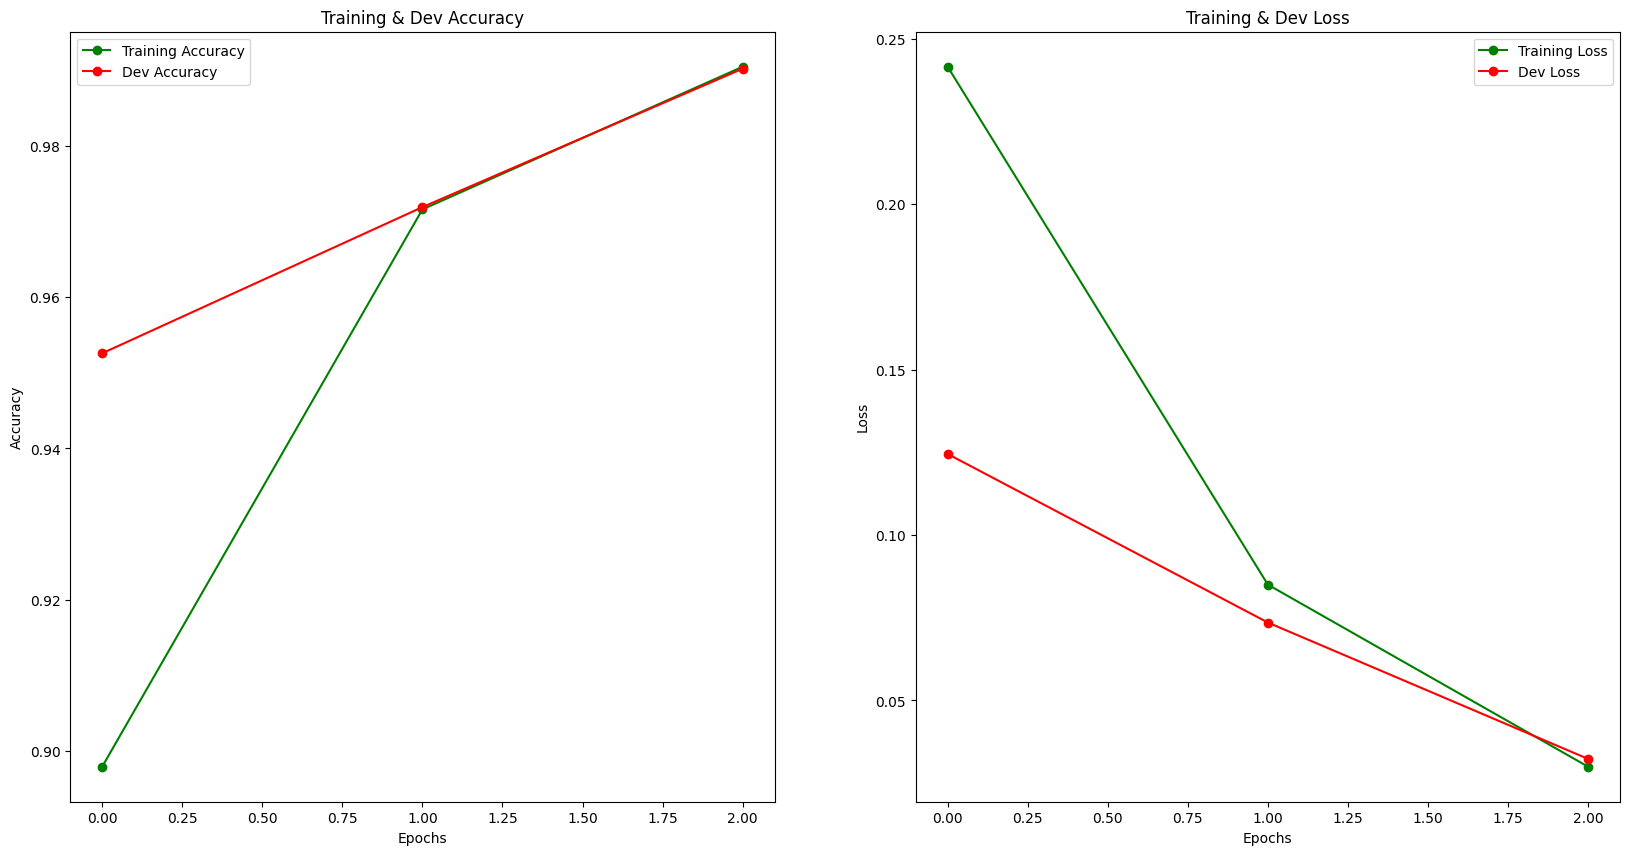

In [49]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Dev Accuracy')
ax[0].set_title('Training & Dev Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Dev Loss')
ax[1].set_title('Training & Dev Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

You can see that the loss essentially decreases on each epoch, which could suggest further training may slightly improve accuracy even further. In the first run, where I have used 10 epochs it was even more obvious. You can find more details about it in the README.md file.

In [50]:
pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

245/245 [==============================] - 117s 470ms/step
              precision    recall  f1-score   support

        Fake       0.46      1.00      0.63      3582
    Not Fake       0.00      0.00      0.00      4240

    accuracy                           0.46      7822
   macro avg       0.23      0.50      0.31      7822
weighted avg       0.21      0.46      0.29      7822



In [51]:
confusion_matrix(y_test,pred)

array([[3582,    0],
       [4240,    0]], dtype=int64)

The confusion matrix shows no particular bias to false negatives or false positives. Now, let's try the model on some articles taken from the web. The first is a BBC news article about the Portland protests (not fake), while the second is a well-known fake news article about Hillary Clinton.

But to do this I need also some text processing for the text entry. So I will create a function for this and that it is reusable.

In [52]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

Now I can enter the news and check the prediction of the model.

In [53]:
real_title = "Portland protests: Trump threatens to send officers to more US cities"
real_text = "President Donald Trump has threatened to send more federal law enforcement officers to major US cities to control ongoing protests.\
Mr Trump on Monday criticised a number of cities run by 'liberal Democrats', including Chicago and New York, saying their leaders were afraid to act.\
He said officers sent to Oregon had done a 'fantastic job' restoring order amid days of protests in Portland.\
Democrats accuse Mr Trump of trying to rally his Conservative base.\
President Trump, a Republican, has been trailing in opinion polls behind his Democratic rival, Joe Biden, ahead of November's election.\
Last month, Mr Trump declared himself the 'president of law and order' in the wake of widespread protests over the death in police custody of African-American man George Floyd.\
Speaking at the White House on Monday, Mr Trump reiterated his call for law and order.\
'We're sending law enforcement,'' he told reporters. 'We can't let this happen to the cities.'\
He specifically named New York City, Chicago, Philadelphia, Detroit, Baltimore and Oakland in discussing problems with violence."

fake_title = "FBI Agent, Who Exposed Hillary Clinton Cover-up, Found Dead"
fake_text = "An FBI Special Agent, who was anticipated to expose the extent of Clinton and Obama malpractice and corruption in the “Operation Fast and Furious” \
cover-up before a US Federal Grand Jury, has been found dead at his home. The FBI official’s wife was also found dead at the scene with the couple both being murdered \
using the 52-year-old agent’s own gun.Special Agent David Raynor was “stabbed multiple times” and “shot twice with his own weapon,” according to local media reports. \
Raynor’s tragic death comes just one day before he was due to testify before a US Federal Grand Jury. \
He was widely expected to testify that Hillary Clinton acted illegally to protect Obama administration crimes while covering up the Fast and Furious scandal. \
Raynor’s wife, Donna Fisher, was also found dead at the scene. An autopsy will be completed to determine the exact cause of death, according to police. According to the \
Baltimore Sun:Authorities, who are offering a $215,000 reward for tips in Suiter’s killing, have struggled to understand what happened. \
The detective was shot with his own gun, which was found at the scene. Two other shots were fired from the gun, and Davis said there were signs of a brief \
struggle.Special Agent Raynor’s suspicious death is the latest in a sequence of disturbing deaths in Baltimore connected to the Clinton/Obama cover-up of \
Operation Fast and Furious.When President Trump took power, the US Justice Department opened another investigation into Operation Fast and Furious as it pertained \
to the Baltimore Police Department and impaneled a US Federal Grand Jury. One of the main witnesses was Detective Sean Suiter, an 18-year veteran of the FBI.However, \
Detective Suiter was gunned down in November, in eerily similar circumstances to Special Agent Raynor, also one day before he could testify. \
Special Agent Raynor was leading US Deputy Attorney General Rod Rosenstein’s and FBI Director Christopher Wray’s investigation into the murder of Detective Sean Suiter. \
Raynor believed Suiter was silenced before he could testify that the Obama administration was criminally complicit in allowing guns to flow into the hands of criminals on the \
Mexican border. \
These guns were involved in the murder of a US Federal Officer, among others, and is seen by investigators as the “Achilles heel of the Obama regime.”The murder of Border \
Patrol Agent Brian Terry is one of but a very few Obama administration crimes that have no statute of limitations as it involved the killing of a US Federal Officer. \
Leaked Wikileaks emails also prove Hillary Clinton was fully knowledgeable about the crime—thus making her liable to criminal charges. \
Last’s week’s bombshell Inspector General’s reports have exposed yet more Hillary Clinton and Obama Administration crimes.The report, that was released last Thursday, \
revealed that the FBI had discovered evidence that Hillary Clinton and the Clinton Foundation had committed “sexual crimes against children.” The report also shows that Obama \
lied to cover-up parts of these investigations that exposed child trafficking.However, the IG report proves that the evidence of these crimes has been covered-up and \
swept under the carpet by those acting at the highest levels."

# Denoise and tokenise the title and article contents and add them to an array
text = [denoise_text(real_title + " " + real_text), denoise_text(fake_title + " " + fake_text)]

tokenized_new = tokenizer.texts_to_sequences(text)
X_new = pad_sequences(tokenized_new, maxlen=max_len)

# Make predictions on the new examples
predictions = np.argmax(model.predict(X_new), axis=1)

mapping = {0: 'Not fake',
           1: 'Fake'}

predictions = np.vectorize(mapping.get)(predictions)

print("BBC News article is predicted to be: {}".format(predictions[0]))
print("Fake news article is predicted to be: {}".format(predictions[1]))

1/1 [==============================] - 1s 825ms/step
BBC News article is predicted to be: Not fake
Fake news article is predicted to be: Not fake


## Conclusion
The model predicts the BBC news article correctly as real news. The fake news article is not predicted correctly. The model predicts it as real news. This is not surprising, because the fake news article is very long and the model is trained with news articles that are much shorter. So the model is not able to predict the fake news article correctly.

The solution could be to add longer news articles to the data and train the model again or to shorten the length of entered news so that the model can handle it better.